# Transformer Autoencoder for Anomaly Detection in Log Data
## Deep Learning and Generative AI Applied to Zookeeper Logs

**Author**: Mika Wilén  
**Thesis project** — Master's Degree Programme in Data Analytics and AI  
Tampere University of Applied Sciences (TAMK), 2025

---

### About this Notebook

This open-source notebook is part of the experimentation and reproducibility work conducted for a Master's thesis research project.  
It demonstrates the use of a **Transformer-based autoencoder** for unsupervised anomaly detection in structured system log files.
The methods presented here contribute to the algorithm selection and repeatability aspects of the research.  
All data and code are intended to be transparent and reproducible.

---

### Overview

This notebook demonstrates the use of a **Transformer-based autoencoder** for detecting anomalies in structured system log data. It is part of a master's thesis research project that explores how **deep learning models** and **generative AI** can support understanding, identifying, and explaining abnormal events in log files.

The implementation combines:
- A **Transformer autoencoder** to identify structural anomalies in log sequences
- **Generative AI (LLMs)** to produce human-readable explanations for detected anomalies

The method is tested on open log datasets (e.g., [LogPai Zookeeper logs](https://github.com/logpai/loghub)) and reflects real-world characteristics observed in production logs from automated underground drilling systems.

---

### Objective

The goal is to develop a reproducible hybrid workflow that:
1. **Detects anomalies** in time-ordered log sequences using unsupervised deep learning
2. **Explains anomalies** in natural language using LLMs (OpenAI / Ollama)
3. Can be extended and integrated into **real-world CI/CD environments** for automated failure analysis

---

### Included in this notebook

- Data loading and preprocessing (structured log format)
- Sequential data generation
- Transformer autoencoder architecture
- Training and evaluation
- Anomaly detection based on reconstruction error
- Contextual log extraction for anomalies
- LLM-based anomaly explanation (optional, with external API)

---

> **Note**: For research transparency, this notebook also highlights limitations such as partial contamination of the training set with anomalies — an issue commonly encountered in real-world datasets. Despite this, meaningful anomaly patterns are detected and analyzed.



### 1. Environment Setup and Library Imports

In [1]:
# Install necessary libraries
# !pip install pandas numpy tensorflow scikit-learn matplotlib

# Import Libraries
import pandas as pd
import numpy as np
import tensorflow as tf
import random
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Set seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

### 2. Load and Explore Log Data

In [2]:
# Load the structured Zookeeper log data
url = "https://raw.githubusercontent.com/logpai/loghub/refs/heads/master/Zookeeper/Zookeeper_2k.log_structured.csv"
df = pd.read_csv(url)

# Display basic information about the dataset
print(f"shape: {df.shape}")
print(f"columns: {df.columns}")
df.head()


shape: (2000, 10)
columns: Index(['LineId', 'Date', 'Time', 'Level', 'Node', 'Component', 'Id', 'Content',
       'EventId', 'EventTemplate'],
      dtype='object')


,LineId,Date,Time,Level,Node,Component,Id,Content,EventId,EventTemplate
0,1,2015-07-29,"17:41:44,747",INFO,QuorumPeer[myid=1]/0,0:0:0:0:0:0:0:2181:FastLeaderElection,774,Notification time out: 3200,E31,Notification time out: <*>
1,2,2015-07-29,"19:04:12,394",INFO,/10.10.34.11,3888:QuorumCnxManager$Listener,493,Received connection request /10.10.34.11:45307,E40,Received connection request /<*>:<*>
2,3,2015-07-29,"19:04:29,071",WARN,SendWorker,188978561024:QuorumCnxManager$SendWorker,688,Send worker leaving thread,E42,Send worker leaving thread
3,4,2015-07-29,"19:04:29,079",WARN,SendWorker,188978561024:QuorumCnxManager$SendWorker,679,Interrupted while waiting for message on queue,E24,Interrupted while waiting for message on queue
4,5,2015-07-29,"19:13:17,524",WARN,SendWorker,188978561024:QuorumCnxManager$SendWorker,688,Send worker leaving thread,E42,Send worker leaving thread


### 3. Feature Engineering and Preprocessing

In [3]:
from sklearn.preprocessing import StandardScaler

# Convert Date and Time columns to a single timestamp column with microsecond precision
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time'], format="%Y-%m-%d %H:%M:%S,%f")

# Calculate microseconds from the start of the log
start_time = df['timestamp'].min()
df['microseconds_from_start'] = (df['timestamp'] - start_time).dt.total_seconds() * 1_000_000

# Encode Log Level to numeric values
df['Level'] = df['Level'].astype(str).str.strip().str.upper().map({'INFO': 0, 'WARN': 1, 'ERROR': 2, 'DEBUG': 3})

# One-hot encode the Component column
component_encoded = pd.get_dummies(df['Component'], prefix='component')

# Concatenate all relevant features into a single DataFrame
processed_df = pd.concat([df[['timestamp', 'microseconds_from_start', 'Level']], component_encoded], axis=1)

# Scale continuous features (microseconds_from_start and Level)
scaler = StandardScaler()
processed_df[['microseconds_from_start', 'Level']] = scaler.fit_transform(processed_df[['microseconds_from_start', 'Level']])

# Display the first few rows of the prepared DataFrame
print("Prepared DataFrame:")
processed_df.head()


Prepared DataFrame:


,timestamp,microseconds_from_start,Level,component_0.0.0.0/0.0.0.0:2181:Learner,component_0.0.0.0/0.0.0.0:2181:NIOServerCnxn,component_0.0.0.0/0.0.0.0:2181:NIOServerCnxnFactory,component_0.0.0.0/0.0.0.0:2181:ZooKeeperServer,component_0:0:0:0:0:0:0:2181:Environment,component_0:0:0:0:0:0:0:2181:FastLeaderElection,component_0:0:0:0:0:0:0:2181:FileTxnSnapLog,...,component_59455:LearnerHandler,component_59480:LearnerHandler,component_DatadirCleanupManager,component_FastLeaderElection,component_FileSnap,component_QuorumCnxManager,component_QuorumCnxManager$Listener,component_QuorumPeer,component_QuorumPeerMain,component_ZooKeeperServer
0,2015-07-29 17:41:44.747,-0.377975,-1.390926,False,False,False,False,False,True,False,...,False,False,False,False,False,False,False,False,False,False
1,2015-07-29 19:04:12.394,-0.370044,-1.390926,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2015-07-29 19:04:29.071,-0.370018,0.678904,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2015-07-29 19:04:29.079,-0.370018,0.678904,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2015-07-29 19:13:17.524,-0.369171,0.678904,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


### 4. Create Time-Based Sequences for the Model

In [5]:
# Define sequence length
sequence_length = 10

# Function to create sequences with timestamps
def create_sequences_with_timestamps(data, timestamps, seq_length):
    sequences, sequence_timestamps = [], []
    for i in range(len(data) - seq_length + 1):
        sequences.append(data.iloc[i:i + seq_length].values)
        sequence_timestamps.append(timestamps.iloc[i])
    return np.array(sequences), sequence_timestamps

# Generate sequences and corresponding timestamps
sequences, sequence_timestamps = create_sequences_with_timestamps(processed_df.drop(columns='timestamp'), processed_df['timestamp'], sequence_length)

# Display the shape of the generated sequences and sample timestamps
print("Shape of Sequential Data:", sequences.shape)
print("Sample Timestamps:", sequence_timestamps[:5])

Shape of Sequential Data: (1991, 10, 72)
Sample Timestamps: [Timestamp('2015-07-29 17:41:44.747000'), Timestamp('2015-07-29 19:04:12.394000'), Timestamp('2015-07-29 19:04:29.071000'), Timestamp('2015-07-29 19:04:29.079000'), Timestamp('2015-07-29 19:13:17.524000')]


### 5. Build the Transformer Autoencoder Model

In [6]:
from tensorflow.keras import layers, models
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Positional Encoding Layer
class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, input_dim):
        super(PositionalEncoding, self).__init__()
        self.position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=input_dim)

    def call(self, x):
        positions = tf.range(start=0, limit=x.shape[1], delta=1)
        encoded_positions = self.position_embedding(positions)
        return x + encoded_positions

# Transformer Encoder Block
def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Multi-head self-attention
    x = layers.MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(inputs, inputs)
    x = layers.Dropout(dropout)(x)
    x = layers.LayerNormalization(epsilon=1e-6)(x + inputs)  # Skip connection and normalization

    # Feed-forward network
    x_ff = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x_ff = layers.Dropout(dropout)(x_ff)
    x_ff = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x_ff)
    return layers.LayerNormalization(epsilon=1e-6)(x + x_ff)  # Skip connection and normalization

# Define the Transformer Autoencoder Model
sequence_length = sequences.shape[1]  # Number of time steps in each sequence
input_dim = sequences.shape[2]        # Number of features per time step

inputs = tf.keras.Input(shape=(sequence_length, input_dim))

# Positional Encoding
x = PositionalEncoding(sequence_length, input_dim)(inputs)

# Transformer Encoder Layers
for _ in range(2):  # Stack multiple transformer encoder layers
    x = transformer_encoder(x, head_size=64, num_heads=2, ff_dim=128, dropout=0.1)

# Decoder (reconstruction layer)
x = layers.Flatten()(x)
x = layers.Dense(sequence_length * input_dim)(x)
x = layers.Reshape((sequence_length, input_dim))(x)

# Model Compilation
model = tf.keras.Model(inputs, x)
model.compile(optimizer='adam', loss='mse')
model.summary()


Num GPUs Available:  0



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 10, 72)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_encoding │ (None, 10, 72)    │        720 │ input_layer[0][0] │
│ (PositionalEncodin… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 72)    │     37,320 │ positional_encod… │
│ (MultiHeadAttentio… │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 10, 72)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 10, 72)    │          0 │ dropout_1[0][0],  │
│                     │                   │            │ positional_encod… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 10, 72)    │        144 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 10, 128)   │      9,344 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 10, 128)   │          0 │ conv1d[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 10, 72)    │      9,288 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 10, 72)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 72)    │        144 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 10, 72)    │     37,320 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 10, 72)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 10, 72)    │          0 │ dropout_4[0][0],  │
│                     │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 10, 72)    │        144 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_2 (Conv1D)   │ (None, 10, 128)   │      9,344 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 10, 128)   │          0 │ conv1d_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 10, 72)    │      9,288 │ dropout_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 10, 72)    │          0 │ layer_normalizat… │
│                     │                   │            │ conv1d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 632,320 (2.41 MB)

 Trainable params: 632,320 (2.41 MB)

 Non-trainable params: 0 (0.00 B)

### 6. Train the Transformer Autoencoder Model with Early Stopping

Epoch 1/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 5s 16ms/step - loss: 0.3093 - val_loss: 0.0267
Epoch 2/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0364 - val_loss: 0.0226
Epoch 3/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0292 - val_loss: 0.0206
Epoch 4/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0253 - val_loss: 0.0180
Epoch 5/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0211 - val_loss: 0.0125
Epoch 6/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0151 - val_loss: 0.0098
Epoch 7/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0125 - val_loss: 0.0086
Epoch 8/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0107 - val_loss: 0.0072
Epoch 9/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0091 - val_loss: 0.0063
Epoch 10/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0080 - val_loss: 0.0060
Epoch 11/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0075 - val_loss: 0.0058
Epoch 12/100
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step

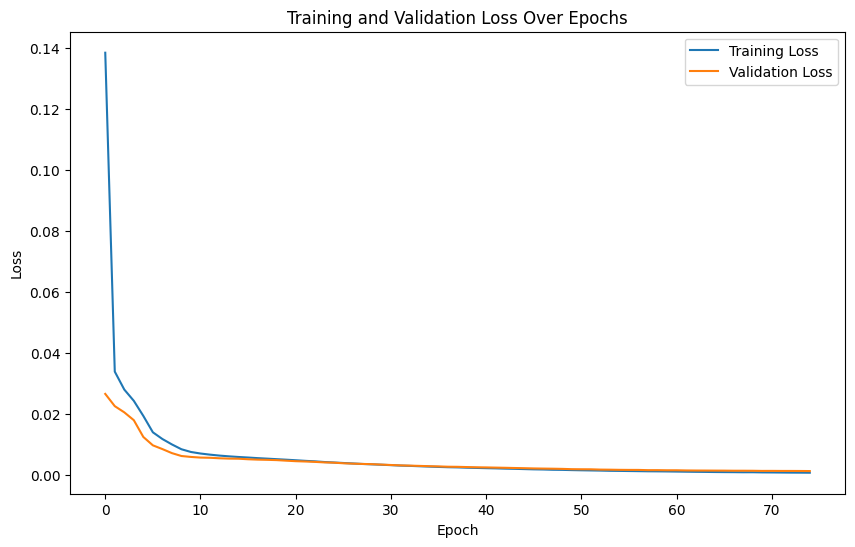

In [7]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping

# Split data into training and testing sets
X_train, X_test = train_test_split(sequences, test_size=0.2, random_state=42)

# Ensure the data type is compatible with TensorFlow
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)

early_stopping = EarlyStopping(
    monitor='val_loss',          # Monitor the validation loss
    patience=5,                  # Reduce patience to stop training sooner
    min_delta=1e-4,              # Minimum improvement to qualify as a loss reduction
    restore_best_weights=True    # Restore weights from the epoch with the best validation loss
)

# Train the model with early stopping
history = model.fit(
    X_train, X_train,  # Autoencoders use input as target
    epochs=100,        # Set a high number of epochs; training will stop early if needed
    batch_size=32,
    validation_data=(X_test, X_test),
    callbacks=[early_stopping]
)

# Display training and validation loss history
print("Training complete. Loss history:")
print(history.history)

import matplotlib.pyplot as plt

# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()


### 7. Detect and Inspect Anomalies Based on Reconstruction Error

In [8]:
# Use the model to reconstruct the sequences in the test set
X_pred = model.predict(X_test)

# Calculate Mean Squared Error (MSE) between original and reconstructed sequences
mse = np.mean(np.power(X_test - X_pred, 2), axis=(1, 2))

# Set anomaly detection threshold: mean MSE + 3 standard deviations
threshold = np.mean(mse) + 3 * np.std(mse)

# Identify anomalies based on the threshold
anomalies = mse > threshold

# Retrieve timestamps of detected anomalies
anomaly_timestamps = [sequence_timestamps[i] for i, is_anomaly in enumerate(anomalies) if is_anomaly]

# Print basic anomaly detection results
print(f"Total anomalies detected: {np.sum(anomalies)}")
print("Anomaly timestamps:")
for ts in anomaly_timestamps:
    print(" -", ts)
print(f"Anomaly detection threshold: {threshold:.6f}\n")

# Print contextual logs for each detected anomaly
print("Context logs for each detected anomaly:\n")

for i, ts in enumerate(anomaly_timestamps):
    # Get a 10-second log window after the anomaly timestamp
    contextual_log = df[(df['timestamp'] >= ts) & (df['timestamp'] <= ts + pd.Timedelta(seconds=10))]

    print(f"--- Anomaly {i+1} ---")
    print(f"Timestamp: {ts}")
    if contextual_log.empty:
        print("No log entries found in the 10-second window.")
    else:
        print(contextual_log.to_string(index=False))
    print("\n")

13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Total anomalies detected: 9
Anomaly timestamps:
 - 2015-07-29 19:13:34.382000
 - 2015-07-29 19:17:57.741000
 - 2015-07-29 19:24:36.927000
 - 2015-07-29 19:25:07.079000
 - 2015-07-29 19:25:10.539000
 - 2015-07-29 19:25:23.889000
 - 2015-07-29 19:31:02.243000
 - 2015-07-29 19:33:12.618000
 - 2015-07-29 19:33:42.688000
Anomaly detection threshold: 0.011531

Context logs for each detected anomaly:

--- Anomaly 1 ---
Timestamp: 2015-07-29 19:13:34.382000
 LineId       Date         Time  Level       Node                                Component  Id                                        Content EventId                                  EventTemplate               timestamp  microseconds_from_start
      9 2015-07-29 19:13:34,382      1 SendWorker 188978561024:QuorumCnxManager$SendWorker 679 Interrupted while waiting for message on queue     E24 Interrupted while waiting for message on queue 2015-07-29 19:13:34.382             5509635000.0
     10 2015-0

### 7.1. Anomaly Interpretations

Below is a summary of the 9 detected anomalies and a brief explanation for why each was <b>likely</b> flagged by the Transformer Autoencoder.

1. **Anomaly at 19:13:34.382**  
   Repeated `SendWorker` interruptions (`E24`) and thread exits (`E42`) suggest instability in the message queue or thread handling.

2. **Anomaly at 19:17:57.741**  
   A mix of connection requests (`E40`) and `SendWorker` disruptions (`E24`, `E25`) occurred within milliseconds, indicating a possibly failing handshake or overload.

3. **Anomaly at 19:24:36.927**  
   A dense cluster of connection failures (`E11`), thread interruptions (`E25`), and worker exits (`E42`) — a strong indication of a systemic fault or recovery attempt.

4. **Anomaly at 19:25:07.079**  
   Multiple connection resets and repeated attempts to restart threads within a short window suggest persistent issues in maintaining stable communication.

5. **Anomaly at 19:25:10.539**  
   Continuation of the previous instability — the system seems to struggle to recover as the same failure signatures (`E11`, `E24`, `E25`, `E42`) repeat.

6. **Anomaly at 19:25:23.889**  
   A new wave of connection issues and broken threads (`E11`, `E25`) appears right after earlier disruptions, possibly signaling a second fault cascade.

7. **Anomaly at 19:31:02.243**  
   Synchronized errors on both `SendWorker` and `RecvWorker`, including multiple `E11`, `E24`, and `E25` logs — an unusual and critical moment of failure.

8. **Anomaly at 19:33:12.618**  
   Another dense event cluster: interruptions, thread exits, and broken connections. This temporal spike in abnormal logs likely triggered the detection.

9. **Anomaly at 19:33:42.688**  
   Similar to previous ones, this shows repeated send/receive failures and a connection break — resembling an unresolved or recurring issue pattern.

Each anomaly consists of log sequences that deviate significantly from normal operational flow, both in content and timing. These patterns justify their classification as outliers by the model.


### 7.2. Visualize Anomalies on Timeline

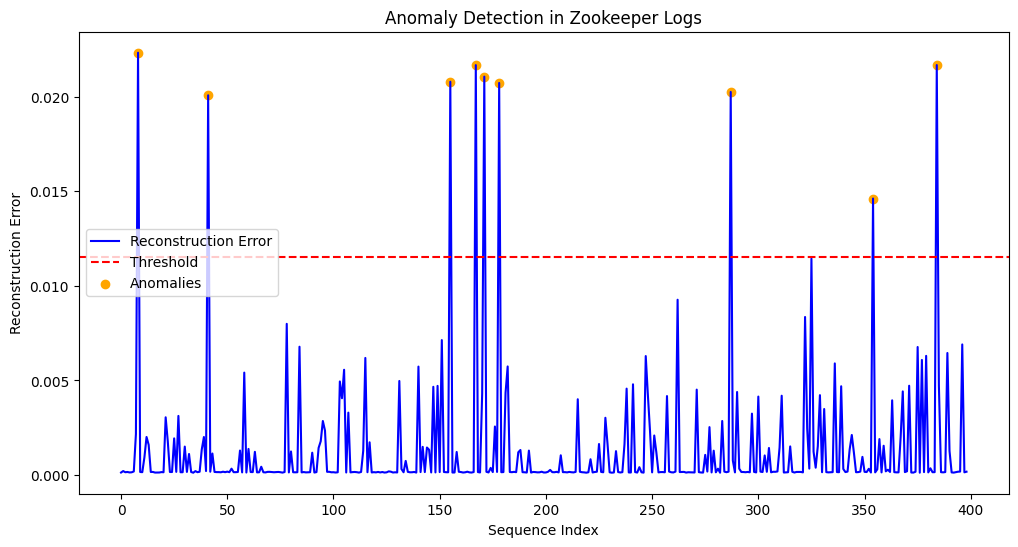

In [9]:
import matplotlib.pyplot as plt

# Plot reconstruction error for each sequence
plt.figure(figsize=(12, 6))
plt.plot(mse, label='Reconstruction Error', color='blue')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')

# Highlight anomalies
anomaly_indices = np.where(anomalies)[0]
plt.scatter(anomaly_indices, mse[anomaly_indices], color='orange', label='Anomalies')

# Add labels and title
plt.xlabel('Sequence Index')
plt.ylabel('Reconstruction Error')
plt.title('Anomaly Detection in Zookeeper Logs')
plt.legend()

# Show the plot
plt.show()

### 7.3. Reconstruction Error Distribution

The histogram above visualizes the reconstruction errors from the Transformer Autoencoder model. The majority of sequences cluster around low error values, while a few significantly deviate and cross the red threshold line — these are considered anomalies.

The threshold is defined as the mean error plus three standard deviations. This statistical boundary ensures that only rare, high-error cases are flagged, reducing the risk of false positives.

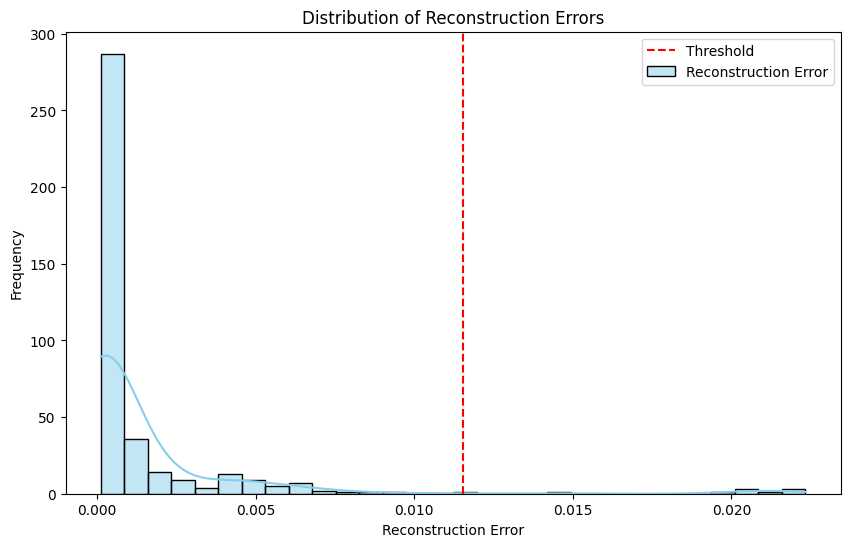

In [31]:
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.histplot(mse, bins=30, kde=True, color='skyblue', label='Reconstruction Error')
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.title('Distribution of Reconstruction Errors')
plt.legend()
plt.show()

### 8. GenAI for Explaining Anomalies by Context Logs

This section introduces a novel method: using Generative AI to explain anomalies detected in log data.
Instead of only flagging outliers, we provide raw log context to a language model for human-readable diagnostics.
The model is prompted to act like an expert engineer, focusing on one anomaly at a time.
It generates clear, actionable explanations to aid in root cause analysis.
This enhances the interpretability and practical value of anomaly detection.

### 8.1. System Prompt and User Prompt

In [14]:
# Define the system prompt for anomaly detection and explanation
system_prompt = (
    "You are a highly skilled software engineer with expertise in diagnosing and explaining anomalies based on log entries. "
    "The log lines you receive describe a single, specific anomaly that needs analysis. "
    "Your task is to thoroughly analyze this unique anomaly, explain its potential causes, and suggest specific actions to resolve it. "
    "Avoid listing multiple potential anomalies and instead provide a focused explanation of this single issue and its most likely root cause. "
    "Keep your response clear, actionable, and suitable for software engineers who need to understand the issue and implement a fix."
)
print(system_prompt)

# Extract 30s window of logs around the first anomaly timestamp
ts = anomaly_timestamps[0]  # First anomaly
contextual_log = df[
    (df['timestamp'] >= ts) &
    (df['timestamp'] <= ts + pd.Timedelta(seconds=30))
]
contextual_log_str = contextual_log.to_string(index=False)

# Define the user prompt with context for the first anomaly in the log
user_prompt = (
    "Here are log entries related to a detected anomaly for analysis:\n\n"
    f"{contextual_log_str}\n"
)
print(user_prompt)


You are a highly skilled software engineer with expertise in diagnosing and explaining anomalies based on log entries. The log lines you receive describe a single, specific anomaly that needs analysis. Your task is to thoroughly analyze this unique anomaly, explain its potential causes, and suggest specific actions to resolve it. Avoid listing multiple potential anomalies and instead provide a focused explanation of this single issue and its most likely root cause. Keep your response clear, actionable, and suitable for software engineers who need to understand the issue and implement a fix.
Here are log entries related to a detected anomaly for analysis:

 LineId       Date         Time  Level                        Node                                Component  Id                                                   Content EventId                                      EventTemplate               timestamp  microseconds_from_start
      9 2015-07-29 19:13:34,382      1                  Se

### 8.2. GenAI Explanation with OpenAI (requires a token)

In [ ]:
# Optional: Generate GenAI explanation for the first anomaly using OpenAI
# Requires OpenAI API key set in environment variable OPENAI_API_KEY

import os
from openai import OpenAI

# Initialize OpenAI client if API key is available
api_key = os.environ.get("OPENAI_API_KEY")
if api_key:
    client = OpenAI(api_key=api_key)

    response = client.chat.completions.create(
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": user_prompt},
        ],
        model="gpt-3.5-turbo",
    )

    print(response.choices[0].message.content)
else:
    print("OpenAI API key not found. Skipping GenAI analysis. Set OPENAI_API_KEY to enable.")


### Anomaly Analysis:

#### Description:
The anomaly detected in the log entries is related to the "Connection broken" events occurring in the QuorumCnxManager component. Specifically, there are multiple occurrences of "Connection broken for id" events within a short time frame.

#### Potential Root Cause:
1. **Network Instability**: The "Connection broken" events indicate a disruption in the network connectivity or stability between the nodes involved in the communication process. This could be due to network latency, packet loss, hardware issues, or misconfigurations.
   
#### Actions to Resolve:
1. **Network Health Check**: Conduct a thorough network health check to identify any issues with the network infrastructure. Verify the connectivity between the nodes and investigate for any network congestion or interruptions.
   
2. **Configuration Review**: Validate the configurations of the QuorumCnxManager component to ensure they align with the requirements and best practices. Check fo

### 8.3. GenAI Explanation with Ollama (requires installation)

In [16]:
# Optional: Generate GenAI explanation for the first anomaly using Ollama
# Requires Ollama to be installed and running with a model like 'llama3.2'

import ollama

# Create the messages list
messages = [
    {'role': 'system', 'content': system_prompt},
    {'role': 'user', 'content': user_prompt}
]

# Generate a response
response = ollama.chat(model='llama3.2', messages=messages)

# Print the response
print(response['message']['content'])

Analysis of the Anomaly:

The detected anomaly is a series of events indicating intermittent connection breaks and send worker exits, which may be causing inconsistent communication between nodes in a Quorum system.

**Potential Cause:**

Based on the log entries, it appears that there is an intermittent issue with the connection between two nodes in the system. The connection is being established and then broken repeatedly, leading to the Send Worker thread exiting multiple times (Lines 10-11). The Connection Broken event for node `188978561024` indicates a persistent issue with maintaining stable connections (Lines 12).

**Likely Root Cause:**

The most likely root cause of this anomaly is a misconfiguration or incomplete initialization of the QuorumCnxManager. Specifically, the failure to establish and maintain reliable connections between nodes may be due to issues such as:

* Insufficient network connectivity between nodes
* Incorrect node ID configuration
* Inadequate connection 